<a href="https://colab.research.google.com/github/lecfghj/Fraud-Detection-Model/blob/main/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import GaussianNoise
from imblearn.under_sampling import RandomUnderSampler


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/creditcard.csv")

Mounted at /content/drive


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Check for missing values

In [4]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [5]:
# Define df with principal components and a predictor variable
X = df.drop('Class', axis=1)
y = df['Class']


In [6]:
# Check the range of features
print(X.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [7]:
df_fraud = df.loc[df['Class'] == 1]

# Create a DataFrame with only Class 0
df_non_fraud = df.loc[df['Class'] == 0][:492]

balanced_df = pd.concat([df_fraud, df_non_fraud])


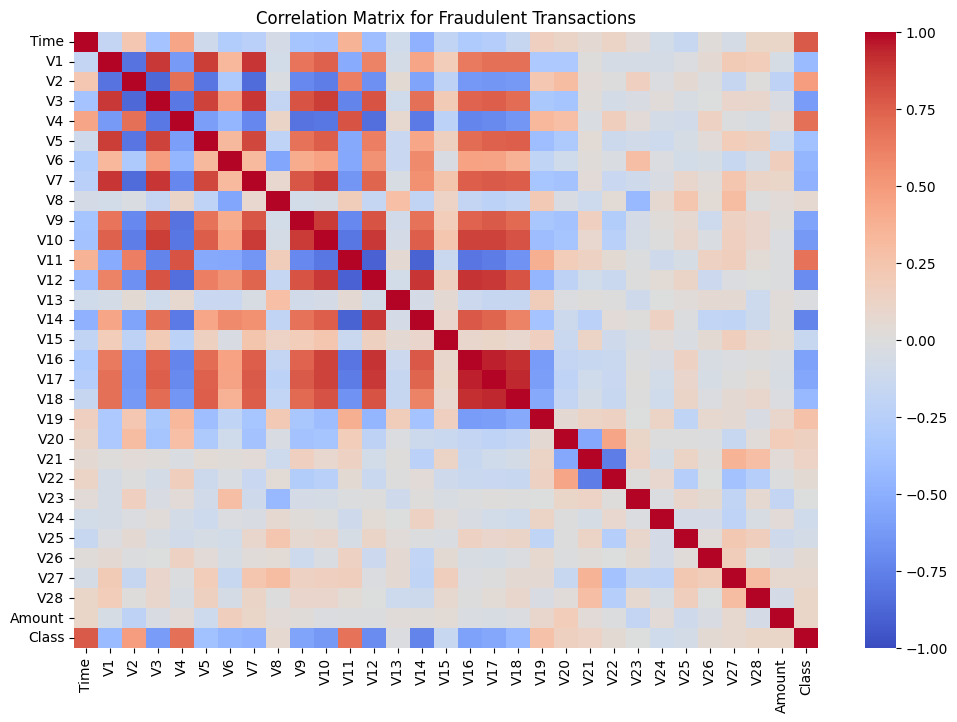

In [8]:
corr_matrix = balanced_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Fraudulent Transactions')
plt.show()

From heatmap it is observed that features V2, V4, V3, V9, V10, V12, V14 and V11 are highly correlated with Class variable.

It's important to try to reduce noise in these features. Use autoencoder to exclude outliers.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Filters outliers from the training set using an autoencoder based on reconstruction error.
def filter_outliers_autoencoder(X_train, y_train, selected_features, outlier_threshold=95, epochs=50, batch_size=32):

    # Normalize the selected features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[selected_features])

    # Split the data into training and validation sets
    X_train_auto, X_test_auto = train_test_split(X_scaled, test_size=0.2, random_state=42)

    # Build the autoencoder model
    autoencoder = Sequential([
        Dense(8, activation='relu', input_shape=(X_train_auto.shape[1],)),
        Dense(4, activation='relu'),
        Dense(8, activation='relu'),
        Dense(X_train_auto.shape[1], activation='linear')
    ])

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the autoencoder
    autoencoder.fit(X_train_auto, X_train_auto, epochs=epochs, batch_size=batch_size, validation_data=(X_test_auto, X_test_auto), verbose=0)

    # Get the reconstruction errors for the entire X_train dataset
    X_pred = autoencoder.predict(X_scaled)
    reconstruction_error = np.mean(np.abs(X_pred - X_scaled), axis=1)

    # Define the threshold for outliers
    threshold = np.percentile(reconstruction_error, outlier_threshold)

    # Identify non-outliers (those below the threshold)
    non_outliers = reconstruction_error < threshold

    # Filter the original X_train and y_train to remove outliers
    X_train_filtered = X_train[non_outliers]
    y_train_filtered = y_train[non_outliers]

    return X_train_filtered, y_train_filtered


In [10]:
# Undersample
from sklearn.utils import shuffle

def undersample(X, y, desired_samples_class_0):
    class_0 = X[y == 0]
    class_1 = X[y == 1]

    # Randomly undersample the majority class
    class_0_undersampled = class_0.sample(n=desired_samples_class_0, random_state=42)

    # Combine the classes
    X_balanced = pd.concat([class_0_undersampled, class_1])
    y_balanced = pd.concat([pd.Series([0] * desired_samples_class_0), pd.Series([1] * len(class_1))])

    # Shuffle the dataset
    X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

    return X_balanced, y_balanced


In [11]:
# Function for oversampling
def oversample(X, y, target_minority_samples):
    ros = RandomOverSampler(sampling_strategy={1: target_minority_samples}, random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
    return X_ros, y_ros


In [12]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Select the features to include in the autoencoder
selected_features = ['V2', 'V4', 'V11', 'V3', 'V9', 'V10', 'V12', 'V14']

# Fit and resample the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, y_train = filter_outliers_autoencoder(X_train, y_train, selected_features)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7121/7121 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [16]:
# Store models for comparison
classifiers = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight={0: 1, 1: 5}, n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'LightGBM': LGBMClassifier(
    class_weight={0: 1, 1: 3},
    colsample_bytree=0.71,
    learning_rate=0.14,
    max_depth=7,
    min_child_samples=10,
    min_child_weight=1,
    n_estimators=100,
    subsample=0.8,
    random_state=42,
    verbose = -1
)
}

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Fit models and evaluate
for name, model in classifiers.items():
    if name in ['Logistic Regression', 'KNN', 'SVM']:
        model.fit(X_train_scaled, y_train_resampled)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print(f'\nModel: {name}')
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'ROC AUC Score: {roc_auc:.4f}')

    print(confusion_matrix(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)


Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     56864
           1       0.01      0.88      0.02        98

    accuracy                           0.81     56962
   macro avg       0.50      0.84      0.45     56962
weighted avg       1.00      0.81      0.89     56962

ROC AUC Score: 0.9179
[[45851 11013]
 [   12    86]]

Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56864
           1       0.02      0.91      0.03        98

    accuracy                           0.90     56962
   macro avg       0.51      0.91      0.49     56962
weighted avg       1.00      0.90      0.95     56962

ROC AUC Score: 0.9576
[[51404  5460]
 [    9    89]]

Model: KNN
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     56864
           1       0.01      0.91      0.02        98

    accuracy  

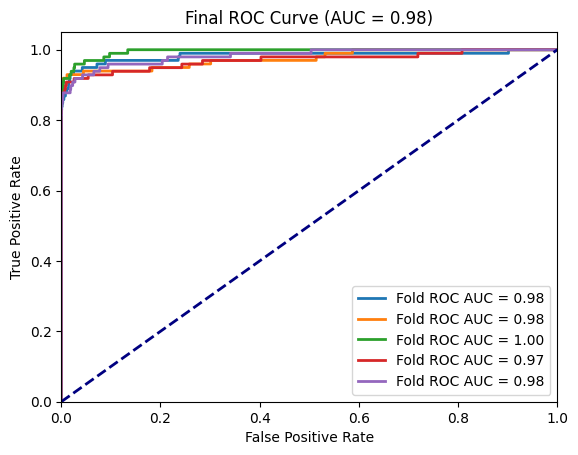

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.62      0.86      0.72       492

    accuracy                           1.00    284807
   macro avg       0.81      0.93      0.86    284807
weighted avg       1.00      1.00      1.00    284807

Confusion Matrix on Test Set:
[[284056    259]
 [    70    422]]


In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store results
all_predictions = []
all_y_true = []
all_y_proba = []  # Store predicted probabilities for ROC AUC
mean_fpr = np.linspace(0, 1, 100)  # Interpolation points for FPR

desired_samples_class_0 = 15000  # Target number of majority samples
target_minority_samples = 4500    # Target number of minority samples


for train_index, test_index in cv.split(X, y):
    # Split into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

     # Undersample the training data
    X_balanced, y_balanced = undersample(X_train, y_train, desired_samples_class_0)

    # Oversample the minority class
    X_ros, y_ros = oversample(X_balanced, y_balanced, target_minority_samples)

    # Apply SMOTE
    smoteenn = SMOTEENN(random_state=42)
    smote = SMOTE(random_state=42)
    adasyn = ADASYN(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_ros, y_ros)

    # Initialize the model inside the loop to ensure fresh model per fold
    model = LGBMClassifier(
    class_weight={0: 1, 1: 1},
    colsample_bytree=0.71,
    learning_rate=0.14,
    max_depth=7,
    min_child_samples=10,
    min_child_weight=1,
    n_estimators=100,
    subsample=0.8,
    random_state=42,
    verbose = -1
)

    model.fit(X_smote, y_smote)

    # Predict on the original testing set
    y_pred_test = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Store predictions and true values for later evaluation
    all_predictions.extend(y_pred_test)  # Collect predictions
    all_y_true.extend(y_test)  # Collect true values
    all_y_proba.extend(y_pred_proba)

    # Calculate ROC curve for this fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, lw=2, label=f'Fold ROC AUC = {roc_auc:.2f}')

# Final ROC AUC Calculation
fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Final ROC Curve (AUC = {roc_auc:.2f})')
plt.legend(loc="lower right")
plt.show()

print("Classification Report on Test Set:")
print(classification_report(all_y_true, all_predictions))
print("Confusion Matrix on Test Set:")
print(confusion_matrix(all_y_true, all_predictions))

In this chunk I am trying to minimise the number of false positives specifically classified by LGBM by using custom prediction threshold.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7121/7121 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

LightGBM Model:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56864
           1       0.02      0.94      0.03        98

    accuracy                           0.90     56962
   macro avg       0.51      0.92      0.49     56962
weighted avg       1.00      0.90      0.95     56962

Confusion Matrix:
[[51252  5612]
 [    6    92]]

LightGBM Model (with threshold = 0.97):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.13        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix (with custom threshold):
[[55723  1141]
 [    9    89]]
ROC AUC Score: 0.9726


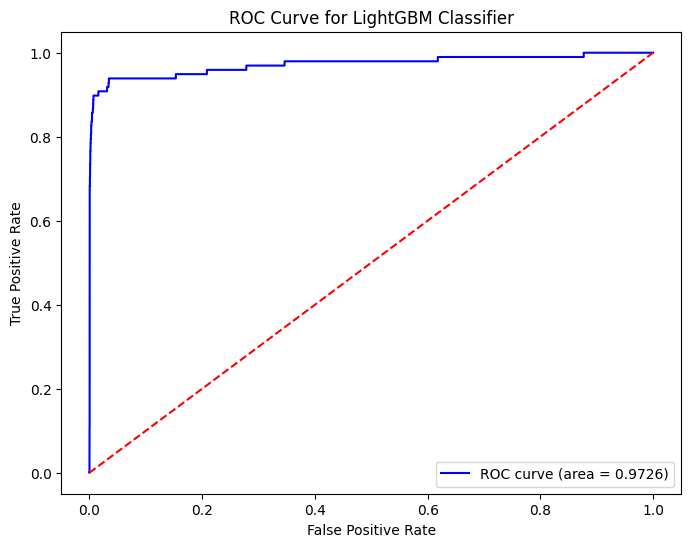

In [20]:
selected_features = ['V2', 'V4', 'V11', 'V3', 'V9', 'V10', 'V12', 'V14']

# Apply Random Undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42, stratify=y)

# Filter outliers using the autoencoder function (assuming you have this function defined)
X_train, y_train = filter_outliers_autoencoder(X_train, y_train, selected_features)

# Apply undersampling on the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# LightGBM Classifier
lgbm_model = LGBMClassifier(
    class_weight={0: 1, 1: 3},
    colsample_bytree=0.71,
    learning_rate=0.14,
    max_depth=7,
    min_child_samples=10,
    min_child_weight=1,
    n_estimators=100,
    subsample=0.8,
    random_state=42,
    verbose=-1
)

# Fit the model
lgbm_model.fit(X_train_resampled, y_train_resampled)
y_pred = lgbm_model.predict(X_test)
y_proba = lgbm_model.predict_proba(X_test)[:, 1]

# Evaluation
print('\nLightGBM Model:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Apply custom threshold for class label classification
threshold = 0.97
y_proba = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_custom_threshold = (y_proba >= threshold).astype(int)

# Evaluation with custom threshold
print(f'\nLightGBM Model (with threshold = {threshold}):')
print(classification_report(y_test, y_pred_custom_threshold))
print('Confusion Matrix (with custom threshold):')
print(confusion_matrix(y_test, y_pred_custom_threshold))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM Classifier')
plt.legend()
plt.show()

Here I am trying to oversample with smote only, without filtering outliers in important features.
After that, I am fitting LGBM with optimal parameters and define a threshold to try to reduce number of false negatives. Number of false negatives was only reduced by 1(from 11 to 10), further reduction of threshold even to very low values doesn't improve classification, only increases number of false negatives.

In [24]:
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

model = LGBMClassifier(
    class_weight={0: 1, 1: 5},
    colsample_bytree=0.75,
    learning_rate=0.12,
    max_depth=None,
    min_child_weight=1,
    n_estimators=100,
    subsample=0.8,
    random_state=42,
    verbose = -1
)
model.fit(X_train_balanced, y_train_balanced)

y_pred = model.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_pred))

# Adjust the decision threshold to tune precision/recall trade-off
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.36 # Changing threshold to a very low value (e.g. 0.1) will stil give 10 false negatives, so 0.36 is the optimal value
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

print("Adjusted Classification Report on Test Set:")
print(classification_report(y_test, y_pred_adjusted))
print("Adjusted Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_pred_adjusted))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.56      0.89      0.69        98

    accuracy                           1.00     56962
   macro avg       0.78      0.94      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix on Test Set:
[[56796    68]
 [   11    87]]
Adjusted Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.90      0.64        98

    accuracy                           1.00     56962
   macro avg       0.75      0.95      0.82     56962
weighted avg       1.00      1.00      1.00     56962

Adjusted Confusion Matrix on Test Set:
[[56775    89]
 [   10    88]]


This code fine-tunes a LightGBM classifier by first selecting key features and splitting the data. It filters outliers, balances the training set with SMOTE, and runs a grid search to find the best hyperparameters based on recall.

In [27]:
# Tuning parameters with CV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# X_train, y_train = filter_outliers_autoencoder(X_train, y_train, selected_features)

smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

model = LGBMClassifier(random_state=42, verbose=-1)

param_grid = {
    'class_weight': [{0: 1, 1: w} for w in [5, 10]],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.15],
    'max_depth': [None, 5, 7],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='average_precision', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced)

print(f'Best Parameters: {grid_search.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'class_weight': {0: 1, 1: 5}, 'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best F1 Score: 1.0000


Final Model Performance Summary:
Balanced Accuracy: 0.9335
Matthews Correlation Coefficient (MCC): 0.8298

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.87      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962



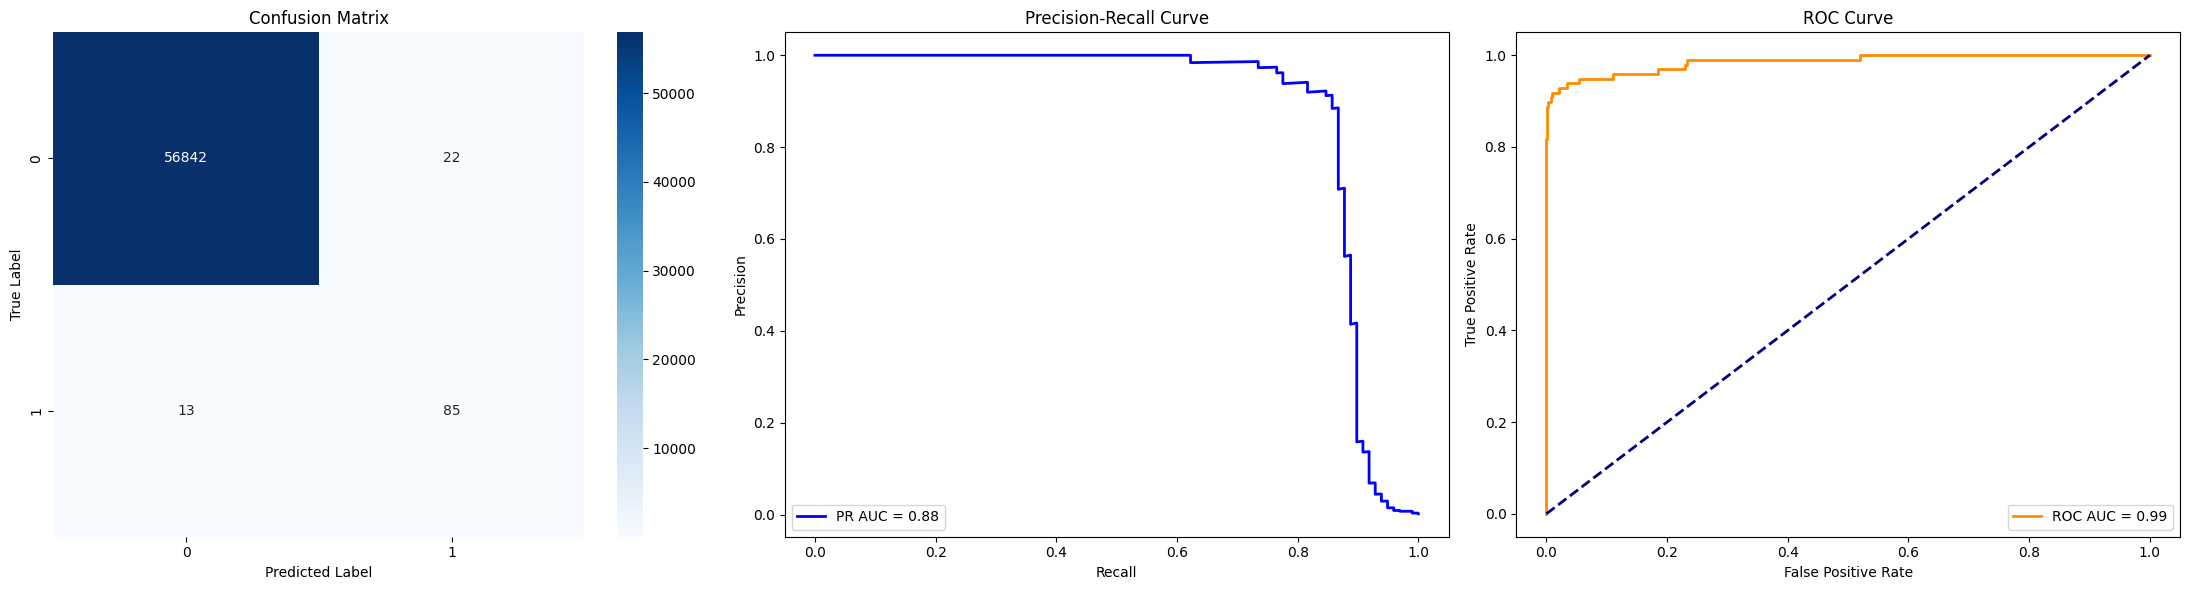

In [28]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef

final_model = grid_search.best_estimator_
y_pred_final = final_model.predict(X_test)
y_proba_final = final_model.predict_proba(X_test)[:, 1]


# Print the key performance metrics
print("Final Model Performance Summary:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_final):.4f}")
print(f"Matthews Correlation Coefficient (MCC): {matthews_corrcoef(y_test, y_pred_final):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))


# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

precision, recall, _ = precision_recall_curve(y_test, y_proba_final)
pr_auc = auc(recall, precision)
axes[1].plot(recall, precision, lw=2, color='blue', label=f'PR AUC = {pr_auc:.2f}')
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left')

fpr, tpr, _ = roc_curve(y_test, y_proba_final)
roc_auc = auc(fpr, tpr)
axes[2].plot(fpr, tpr, lw=2, color='darkorange', label=f'ROC AUC = {roc_auc:.2f}')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].set_title('ROC Curve')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.show()

Final model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

final_model = LGBMClassifier(
    class_weight={0: 1, 1: 5},
    colsample_bytree=0.8,
    learning_rate=0.15,
    max_depth=None,
    min_child_weight=1,
    subsample=0.8,
    random_state=42 ,
    verbose = -1
)
final_model.fit(X_train_balanced, y_train_balanced)

y_pred = final_model.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.87      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix on Test Set:
[[56842    22]
 [   13    85]]
